In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

!nvidia-smi

Sun Jun  9 19:02:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:19:00.0 Off |                  Off |
|  0%   55C    P0             86W /  300W |      11MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, DDPMScheduler, DPMSolverSDEScheduler

controlnet = [ControlNetModel.from_single_file('/data/sd-results/celeba_mesh_controlnet/celeba_mesh_controlnet-step00010000.safetensors',
                                             torch_dtype=torch.float16, use_safetensors=True, variant="fp16"),
             ]

pipe = StableDiffusionControlNetPipeline.from_single_file("/data/sd_files/checkpoint/beautifulRealistic_v7.safetensors",
                                                        controlnet=controlnet,
                                                        torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")
pipe.scheduler = DPMSolverSDEScheduler.from_config(pipe.scheduler.config)
pipe.safety_checker = None

print('done')

/home/scpark/anaconda3/envs/ste/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-09 19:02:18.043725: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 19:02:18.859762: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/scpark/anaconda3/envs/ste/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access Untyped

done


/home/scpark/anaconda3/envs/ste/lib/python3.9/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `use_karras_sigmas` directly via 'DPMSolverSDEScheduler' object attribute is deprecated. Please access 'use_karras_sigmas' over 'DPMSolverSDEScheduler's config object instead, e.g. 'scheduler.config.use_karras_sigmas'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


In [3]:
import cv2
import mediapipe as mp
from PIL import Image
import numpy as np

# Initialize MediaPipe Face Mesh.
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

image_dir = '/data/sd-dataset/celeba'
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
image_files = sorted(image_files)

def get_image(file):
    image_bgr = cv2.imread(file)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    return image_rgb
    
# Define a function to process each image.
def get_mesh_image(image_rgb):
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:
        
        # Convert the BGR image to RGB before processing.
        results = face_mesh.process(image_rgb)

        # If no face landmarks are detected, continue to the next image.
        if not results.multi_face_landmarks:
            return None

        # Create a copy of the image to draw the annotations on.
        h, w, _ = image_rgb.shape
        annotated_image = np.zeros((h, w, 3), dtype=np.uint8)

        # Draw the face mesh landmarks on the image.
        for face_landmarks in results.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                image=annotated_image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1))

        return Image.fromarray(annotated_image)


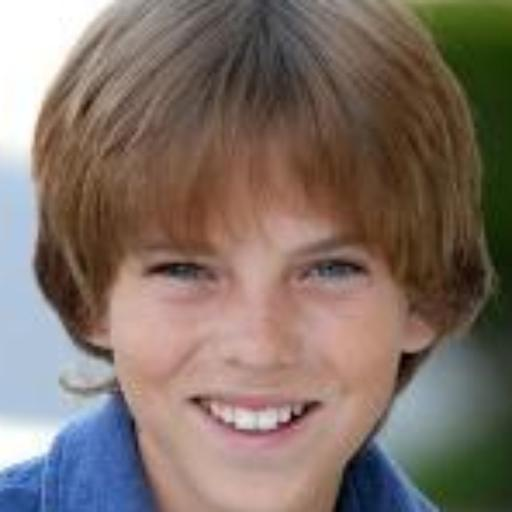

In [4]:
image = get_image(image_files[1000])
Image.fromarray(image)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


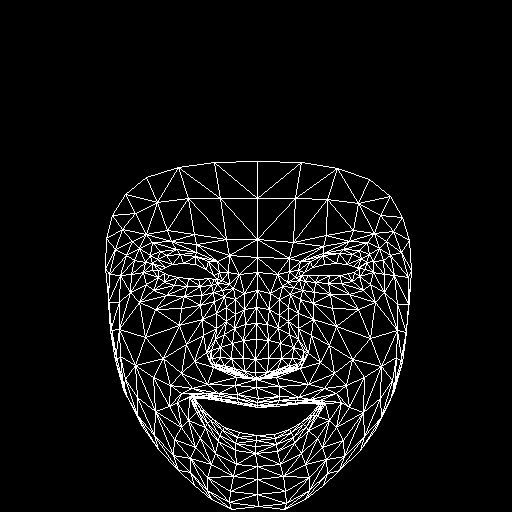

In [5]:
mesh_image = get_mesh_image(image)
mesh_image

 85%|████████████████████████████████████▌      | 17/20 [00:01<00:00, 11.23it/s]/home/scpark/anaconda3/envs/ste/lib/python3.9/site-packages/torchsde/_brownian/brownian_interval.py:599: UserWarning: Should have ta>=t0 but got ta=0.0291675366461277 and t0=0.029168.
  warnings.warn(f"Should have ta>=t0 but got ta={ta} and t0={self._start}.")
100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  9.71it/s]


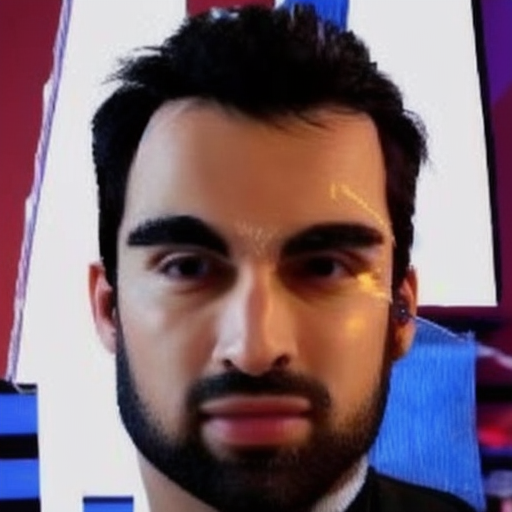

In [6]:
prompt = 'celeba, 5_o_clock_shadow, attractive, bags_under_eyes, big_lips, big_nose, black_hair, bushy_eyebrows, male, no_beard, pointy_nose, straight_hair, young'
#prompt = 'pretty girls'

image = pipe(prompt=prompt,
         image=[mesh_image],
         height=512,
         width=512,
         num_inference_steps=20,
         guidance_scale=7,
        ).images[0]
image
